In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_06_47_01
NN-MODEL FILENAME:  ./models/VBKG0BIX_06_47_01_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, p_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = boundary
    
    
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)

    my_borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = p_table
    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, my_borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, my_borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)

#     GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    new_max = np.array([exp_rec[:,i].max() for i in range(N_STATES)])
    new_min = np.array([exp_rec[:,i].min() for i in range(N_STATES)])
    

    if iteration >= 4: 

        old_max = np.array(boundary[:4])
        old_min = np.array(boundary[4:])

        newboundary_max = old_max
        newboundary_min = old_min

        damper = 0.6
        for i in range(N_STATES):
            newboundary_max[i] = new_max[i] if new_max[i] >= old_max[i] else (old_max[i]*damper+new_max[i]*(1-damper))
            newboundary_min[i] = new_min[i] if new_min[i] <= old_min[i] else (old_min[i]*damper+new_min[i]*(1-damper))
            
            MARGIN = 2*(newboundary_max - newboundary_min)/HI_GRAIN

        newboundary = np.concatenate((newboundary_max + MARGIN,
                                      newboundary_min - MARGIN))
    else:
        MARGIN = 2*(new_max - new_min)/HI_GRAIN
        newboundary = np.concatenate((new_max + MARGIN,
                                      new_min + MARGIN))

        
#   # CLAMP STATE VALUE BORDERS
    ##############################################
    newboundary[0] = clamp(C_POS_ABS_MIN, newboundary[0], C_POS_ABS_MAX)
    newboundary[4] = clamp(C_POS_ABS_MIN, newboundary[4], C_POS_ABS_MAX) 

    newboundary[1] = clamp(C_VEL_ABS_MIN, newboundary[1], C_VEL_ABS_MAX)
    newboundary[5] = clamp(C_VEL_ABS_MIN, newboundary[5], C_VEL_ABS_MAX) 

    newboundary[2] = clamp(P_ANG_ABS_MIN, newboundary[2], P_ANG_ABS_MAX)
    newboundary[6] = clamp(P_ANG_ABS_MIN, newboundary[6], P_ANG_ABS_MAX) 

    newboundary[3] = clamp(P_VEL_ABS_MIN, newboundary[3], P_VEL_ABS_MAX)
    newboundary[7] = clamp(P_VEL_ABS_MIN, newboundary[7], P_VEL_ABS_MAX)
    
#     newboundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
#                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1256.84 MiB, increment: 1036.12 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table
q_table_list = [node_q_table]* NO_OF_NODES




ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15558
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 61
TOTAL SERIAL TIMESTEPS:   15558
TOTAL PARALLEL TIMESTEPS: 61


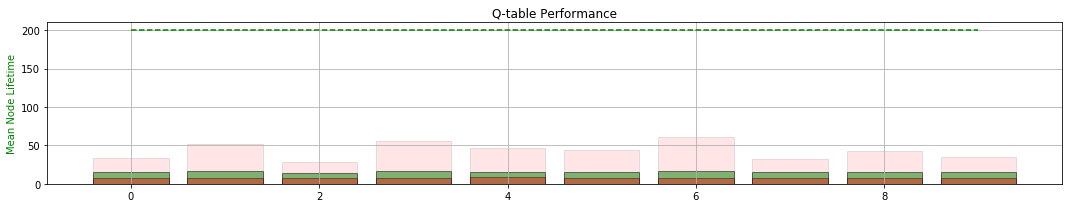

MEMORY COUNTER:  15558
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 554.511	LOSS : 494.187	LOSS : 501.537	LOSS : 462.312	LOSS : 482.520	LOSS : 453.713	LOSS : 461.374	LOSS : 438.435	LOSS : 427.280	LOSS : 426.650	LOSS : 437.595	LOSS : 416.630	LOSS : 417.081	LOSS : 409.456	LOSS : 399.023	LOSS : 386.797	LOSS : 390.277	LOSS : 394.987	LOSS : 370.245	LOSS : 380.651	
Validating... MEAN TIME:  131.065
LOSS : 374.989	LOSS : 378.491	LOSS : 374.128	LOSS : 374.044	LOSS : 373.400	LOSS : 381.074	LOSS : 372.655	LOSS : 385.132	LOSS : 376.238	LOSS : 378.128	LOSS : 380.476	LOSS : 376.502	LOSS : 380.154	LOSS : 392.345	LOSS : 381.279	LOSS : 387.024	LOSS : 396.467	LOSS : 392.471	LOSS : 408.981	LOSS : 388.296	
Validating... MEAN TIME:  141.365
LOSS : 396.223	LOSS : 393.076	LOSS : 399.610	LOSS : 414.616	LOSS : 415.246	LOSS : 419.982	LOSS : 402.952	LOSS : 411.284	LOSS : 414.229	LOSS : 419.704	LOSS : 434.743	LOSS : 443.188	LOSS : 424.811	LOSS : 442.441	LOSS : 444.998	LOSS : 457.682	LOSS : 4

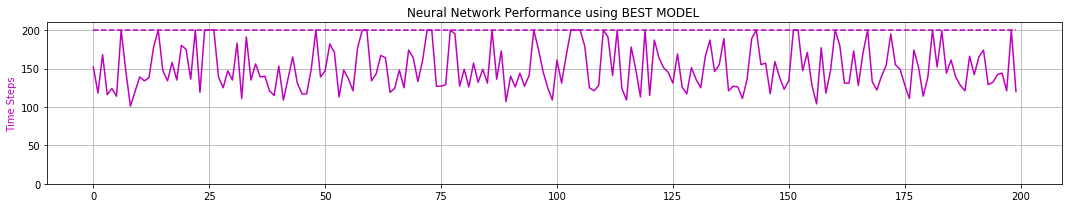

0 -max- [ 0.363  2.327  0.227  1.966]
0 -min- [-0.129 -1.038 -0.189 -2.683]

peak memory: 1314.22 MiB, increment: 1035.37 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.389  2.133  0.224  1.415]
1 -min- [-0.101 -0.796 -0.188 -2.567]

peak memory: 1353.61 MiB, increment: 1035.45 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.270  1.944  0.225  1.890]
2 -min- [-0.152 -0.886 -0.189 -2.529]

peak memory: 1372.84 MiB, increment: 1034.95 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.964  3.882  0.228  2.445]
3 -min- [-0.130 -1.083 -0.188 -3.074]

peak memory: 1392.40 MiB, increment: 1034.83 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.625  2.850  0.228  1.992]
4 -min- [-0.073 -0.798 -0.188 -2.517]

peak memory: 1412.11 MiB, increment: 1034.86 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.380  2.431  0.227  2.001]
5 -min- [-0.136 -0.951 -0.188 -2.521]

peak memory: 1421.69 MiB, increment: 1025.27 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.800  2.492  0.222  1.605]
6 -min- 

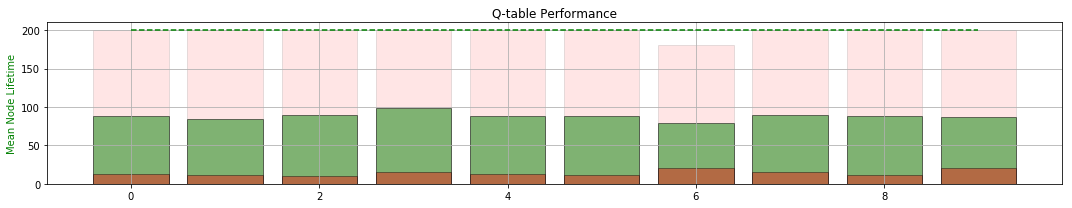

MEMORY COUNTER:  103563
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 596.666	LOSS : 536.903	LOSS : 501.911	LOSS : 452.082	LOSS : 454.591	LOSS : 422.691	LOSS : 404.813	LOSS : 377.910	LOSS : 357.944	LOSS : 352.388	LOSS : 328.338	LOSS : 319.502	LOSS : 318.761	LOSS : 313.561	LOSS : 292.932	LOSS : 296.134	LOSS : 288.271	LOSS : 286.930	LOSS : 285.988	LOSS : 290.837	
Validating... MEAN TIME:  134.425
LOSS : 303.374	LOSS : 286.544	LOSS : 257.106	LOSS : 269.356	LOSS : 275.481	LOSS : 253.702	LOSS : 256.325	LOSS : 249.742	LOSS : 256.567	LOSS : 260.177	LOSS : 250.136	LOSS : 262.894	LOSS : 264.498	LOSS : 264.710	LOSS : 263.936	LOSS : 267.640	LOSS : 263.469	LOSS : 248.839	LOSS : 268.334	LOSS : 275.166	
Validating... MEAN TIME:  144.19
LOSS : 259.397	LOSS : 260.582	LOSS : 253.420	LOSS : 251.041	LOSS : 262.359	LOSS : 271.368	LOSS : 265.770	LOSS : 273.063	LOSS : 276.150	LOSS : 272.654	LOSS : 264.562	LOSS : 265.136	LOSS : 264.982	LOSS : 259.932	LOSS : 272.755	LOSS : 267.125	LOSS : 2

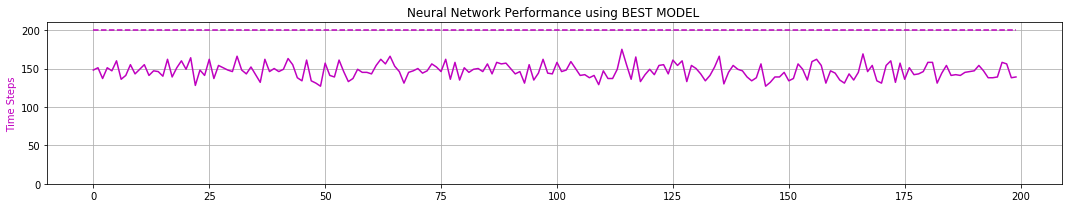

0 -max- [ 1.010  2.125  0.230  3.272]
0 -min- [-0.875 -2.232 -0.188 -2.255]

peak memory: 1551.61 MiB, increment: 1027.66 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 1.101  2.157  0.230  3.171]
1 -min- [-1.092 -2.047 -0.188 -1.969]

peak memory: 1571.39 MiB, increment: 1016.10 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.944  1.962  0.230  3.017]
2 -min- [-0.954 -1.937 -0.188 -2.163]

peak memory: 1587.06 MiB, increment: 1012.34 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.947  2.068  0.230  3.027]
3 -min- [-0.888 -2.142 -0.188 -1.999]

peak memory: 1610.46 MiB, increment: 1016.06 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.133  1.819  0.230  3.385]
4 -min- [-0.825 -2.269 -0.188 -1.862]

peak memory: 1629.99 MiB, increment: 1015.91 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.113  1.955  0.230  3.239]
5 -min- [-1.000 -2.448 -0.188 -2.226]

peak memory: 1668.49 MiB, increment: 1034.99 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.873  1.896  0.230  2.693]
6 -min- 

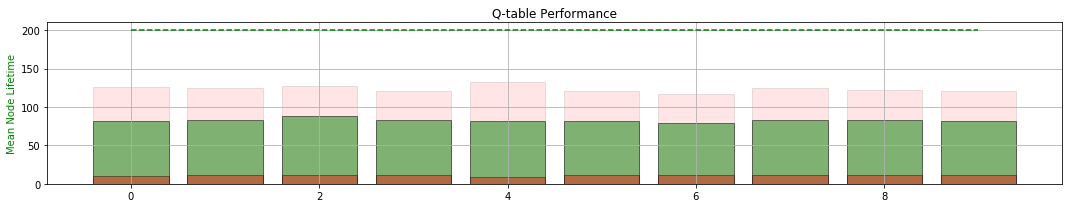

MEMORY COUNTER:  186053
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 318.651	LOSS : 303.702	LOSS : 288.609	LOSS : 306.626	LOSS : 297.010	LOSS : 297.178	LOSS : 290.515	LOSS : 285.968	LOSS : 298.166	LOSS : 330.050	LOSS : 299.919	LOSS : 308.435	LOSS : 267.125	LOSS : 281.120	LOSS : 283.806	LOSS : 301.154	LOSS : 286.972	LOSS : 285.775	LOSS : 296.681	LOSS : 278.572	
Validating... MEAN TIME:  126.055
LOSS : 285.280	LOSS : 285.122	LOSS : 273.315	LOSS : 274.238	LOSS : 264.849	LOSS : 303.079	LOSS : 266.632	LOSS : 277.592	LOSS : 302.762	LOSS : 321.827	LOSS : 303.860	LOSS : 291.992	LOSS : 303.848	LOSS : 306.534	LOSS : 313.040	LOSS : 301.336	LOSS : 293.708	LOSS : 301.199	LOSS : 297.459	LOSS : 328.086	
Validating... MEAN TIME:  126.37
LOSS : 304.859	LOSS : 322.806	LOSS : 318.334	LOSS : 321.531	LOSS : 309.031	LOSS : 306.739	LOSS : 315.215	LOSS : 323.211	LOSS : 343.714	LOSS : 311.984	LOSS : 321.042	LOSS : 331.744	LOSS : 341.241	LOSS : 333.664	LOSS : 339.438	LOSS : 292.061	LOSS : 3

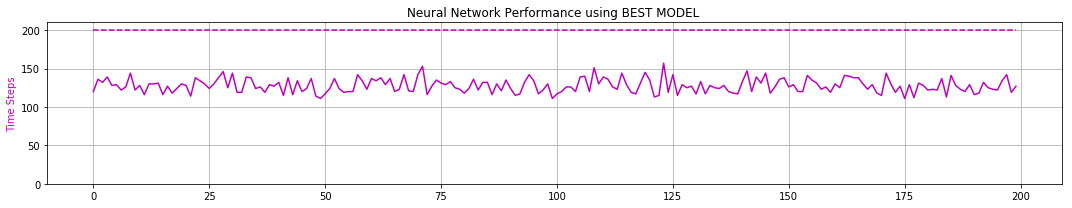

0 -max- [ 0.318  1.231  0.061  1.476]
0 -min- [-2.267 -2.933 -0.196 -1.832]

peak memory: 1693.51 MiB, increment: 976.98 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.321  1.394  0.063  1.182]
1 -min- [-2.270 -2.889 -0.196 -1.535]

peak memory: 1693.51 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.354  1.379  0.085  1.227]
2 -min- [-2.267 -2.939 -0.195 -1.584]

peak memory: 1693.51 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.343  1.422  0.075  1.123]
3 -min- [-2.269 -2.951 -0.196 -1.602]

peak memory: 1693.51 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.336  1.626  0.112  1.572]
4 -min- [-2.268 -3.082 -0.194 -1.985]

peak memory: 1693.51 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.316  1.601  0.064  1.314]
5 -min- [-2.267 -3.119 -0.196 -1.805]

peak memory: 1732.45 MiB, increment: 977.02 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.325  1.378  0.061  1.360]
6 -min- [-2.27

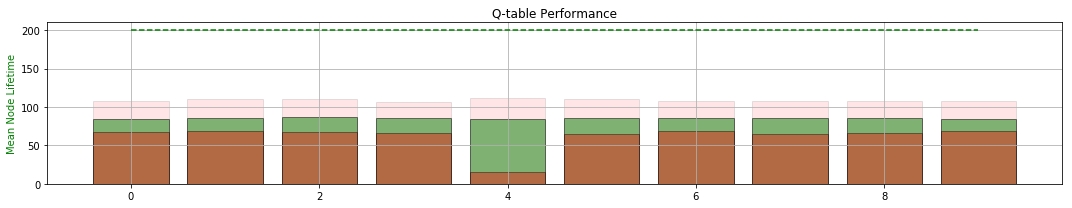

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 223.492	LOSS : 219.227	LOSS : 212.983	LOSS : 205.889	LOSS : 204.564	LOSS : 192.882	LOSS : 192.986	LOSS : 194.772	LOSS : 183.076	LOSS : 189.241	LOSS : 177.505	LOSS : 182.289	LOSS : 180.893	LOSS : 172.002	LOSS : 175.188	LOSS : 175.453	LOSS : 158.048	LOSS : 166.096	LOSS : 177.844	LOSS : 164.973	
Validating... MEAN TIME:  127.26
LOSS : 167.349	LOSS : 175.976	LOSS : 173.668	LOSS : 164.673	LOSS : 172.216	LOSS : 160.927	LOSS : 158.779	LOSS : 176.006	LOSS : 170.156	LOSS : 162.534	LOSS : 179.923	LOSS : 169.073	LOSS : 158.006	LOSS : 160.820	LOSS : 151.568	LOSS : 151.704	LOSS : 161.342	LOSS : 160.892	LOSS : 164.266	LOSS : 161.016	
Validating... MEAN TIME:  112.5
LOSS : 157.061	LOSS : 168.810	LOSS : 162.023	LOSS : 162.995	LOSS : 155.196	LOSS : 163.552	LOSS : 156.685	LOSS : 164.151	LOSS : 154.777	LOSS : 159.782	LOSS : 158.465	LOSS : 152.701	LOSS : 161.245	LOSS : 152.981	LOSS : 151.712	LOSS : 144.463	LOSS : 158

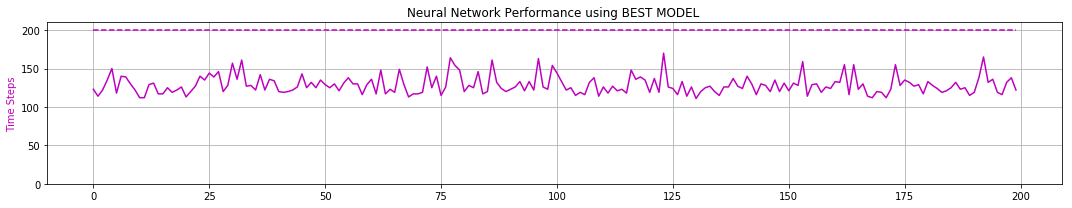

0 -max- [ 0.243  1.001  0.063  0.788]
0 -min- [-1.671 -2.431 -0.196 -1.137]

peak memory: 1849.75 MiB, increment: 977.04 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.246  1.185  0.060  0.763]
1 -min- [-1.683 -2.423 -0.197 -1.278]

peak memory: 1849.75 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.249  1.179  0.061  0.762]
2 -min- [-1.559 -2.220 -0.196 -1.295]

peak memory: 1849.75 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.274  0.991  0.061  0.753]
3 -min- [-1.649 -2.258 -0.197 -1.160]

peak memory: 1849.75 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.255  1.308  0.068  1.023]
4 -min- [-1.686 -2.250 -0.196 -1.565]

peak memory: 1849.75 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.239  1.102  0.061  0.804]
5 -min- [-1.595 -2.249 -0.196 -1.349]

peak memory: 1849.75 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.254  1.133  0.062  0.754]
6 -min- [-1.59

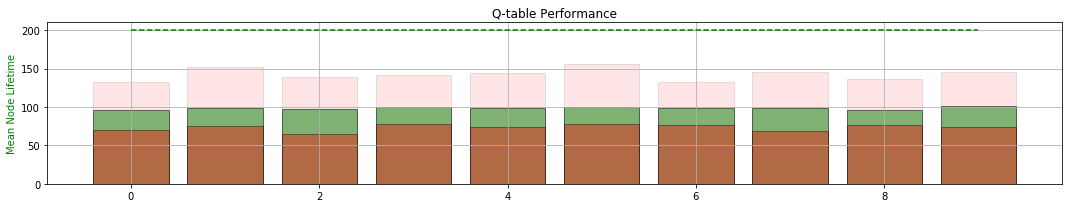

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 135.237	LOSS : 119.586	LOSS : 126.174	LOSS : 125.592	LOSS : 137.319	LOSS : 130.212	LOSS : 136.820	LOSS : 135.295	LOSS : 128.691	LOSS : 126.432	LOSS : 127.358	LOSS : 118.967	LOSS : 119.425	LOSS : 129.990	LOSS : 124.630	LOSS : 134.522	LOSS : 122.340	LOSS : 120.577	LOSS : 113.801	LOSS : 116.705	
Validating... MEAN TIME:  116.32
LOSS : 117.000	LOSS : 120.534	LOSS : 107.338	LOSS : 100.469	LOSS : 108.485	LOSS : 122.041	LOSS : 107.159	LOSS : 103.177	LOSS : 110.540	LOSS : 103.911	LOSS : 108.851	LOSS : 99.060	LOSS : 99.958	LOSS : 104.735	LOSS : 101.532	LOSS : 106.771	LOSS : 95.767	LOSS : 98.805	LOSS : 118.681	LOSS : 111.333	
Validating... MEAN TIME:  58.83
LOSS : 103.890	LOSS : 99.828	LOSS : 126.437	LOSS : 106.024	LOSS : 102.350	LOSS : 101.799	LOSS : 112.570	LOSS : 124.144	LOSS : 100.598	LOSS : 105.984	LOSS : 104.806	LOSS : 111.414	LOSS : 107.642	LOSS : 114.264	LOSS : 110.282	LOSS : 107.695	LOSS : 101.684	

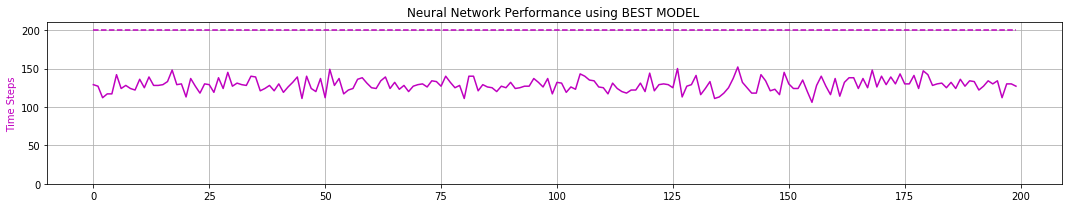

0 -max- [ 1.814  3.709  0.189  4.263]
0 -min- [-2.600 -4.639 -0.250 -4.466]

peak memory: 1668.60 MiB, increment: 969.23 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 1.815  3.770  0.192  4.264]
1 -min- [-2.600 -4.649 -0.250 -4.566]

peak memory: 1812.54 MiB, increment: 976.96 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.821  3.714  0.189  4.341]
2 -min- [-2.600 -4.706 -0.250 -4.477]

peak memory: 1713.32 MiB, increment: 955.48 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.811  3.710  0.189  4.234]
3 -min- [-2.600 -4.642 -0.250 -4.466]

peak memory: 1793.13 MiB, increment: 976.92 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.808  3.709  0.189  4.248]
4 -min- [-2.600 -4.647 -0.250 -4.464]

peak memory: 1831.32 MiB, increment: 995.80 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.821  3.795  0.190  4.320]
5 -min- [-2.600 -4.721 -0.250 -4.576]

peak memory: 1832.07 MiB, increment: 977.14 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.811  3.709  0.190  4.247]
6 -min- [-2.60

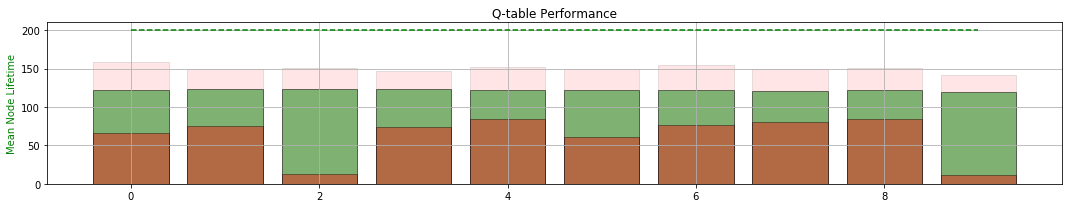

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 154.413	LOSS : 147.885	LOSS : 139.283	LOSS : 137.587	LOSS : 137.485	LOSS : 133.045	LOSS : 126.260	LOSS : 126.677	LOSS : 126.646	LOSS : 124.796	LOSS : 113.225	LOSS : 121.678	LOSS : 121.582	LOSS : 128.278	LOSS : 123.707	LOSS : 124.223	LOSS : 117.703	LOSS : 122.425	LOSS : 115.208	LOSS : 124.461	
Validating... MEAN TIME:  151.195
LOSS : 122.683	LOSS : 125.183	LOSS : 104.762	LOSS : 110.963	LOSS : 111.267	LOSS : 103.773	LOSS : 98.977	LOSS : 98.137	LOSS : 117.712	LOSS : 112.915	LOSS : 102.780	LOSS : 118.078	LOSS : 105.765	LOSS : 120.792	LOSS : 114.826	LOSS : 108.927	LOSS : 113.438	LOSS : 117.259	LOSS : 117.373	LOSS : 105.405	
Validating... MEAN TIME:  81.01
LOSS : 98.209	LOSS : 108.299	LOSS : 103.717	LOSS : 118.767	LOSS : 95.530	LOSS : 114.662	LOSS : 107.693	LOSS : 110.145	LOSS : 97.563	LOSS : 115.795	LOSS : 112.301	LOSS : 111.561	LOSS : 102.888	LOSS : 102.249	LOSS : 99.499	LOSS : 103.789	LOSS : 110.469	

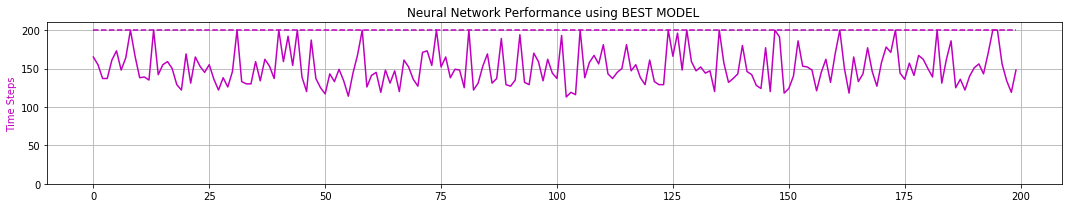

0 -max- [ 1.348  3.064  0.229  4.006]
0 -min- [-2.600 -4.731 -0.250 -4.001]

peak memory: 1855.44 MiB, increment: 976.93 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 1.344  3.090  0.228  3.928]
1 -min- [-2.600 -4.797 -0.250 -4.108]

peak memory: 1855.44 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.351  3.074  0.230  4.099]
2 -min- [-2.600 -4.908 -0.250 -4.048]

peak memory: 1855.44 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.345  3.070  0.230  3.980]
3 -min- [-2.600 -4.850 -0.250 -3.945]

peak memory: 1933.57 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.341  3.068  0.229  3.915]
4 -min- [-2.600 -4.773 -0.250 -3.957]

peak memory: 1855.44 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.347  3.112  0.231  3.965]
5 -min- [-2.600 -4.838 -0.250 -4.096]

peak memory: 1933.57 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.346  3.063  0.224  4.002]
6 -min- [-2.60

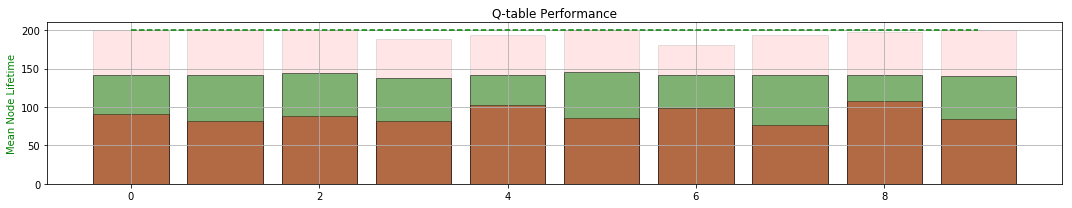

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 89.824	LOSS : 94.461	LOSS : 101.913	LOSS : 107.348	LOSS : 94.299	LOSS : 89.508	LOSS : 89.689	LOSS : 104.502	LOSS : 94.150	LOSS : 104.386	LOSS : 101.656	LOSS : 103.653	LOSS : 93.588	LOSS : 98.867	LOSS : 106.565	LOSS : 110.572	LOSS : 93.283	LOSS : 108.977	LOSS : 102.304	LOSS : 89.298	
Validating... MEAN TIME:  165.005
LOSS : 100.011	LOSS : 85.472	LOSS : 88.666	LOSS : 94.411	LOSS : 87.377	LOSS : 98.458	LOSS : 87.534	LOSS : 98.866	LOSS : 91.099	LOSS : 94.437	LOSS : 95.146	LOSS : 74.645	LOSS : 87.800	LOSS : 85.106	LOSS : 96.283	LOSS : 91.045	LOSS : 85.690	LOSS : 104.839	LOSS : 87.346	LOSS : 89.370	
Validating... MEAN TIME:  142.7
LOSS : 102.050	LOSS : 101.116	LOSS : 82.083	LOSS : 82.827	LOSS : 108.956	LOSS : 88.010	LOSS : 94.023	LOSS : 83.747	LOSS : 88.549	LOSS : 86.253	LOSS : 90.640	LOSS : 104.489	LOSS : 88.525	LOSS : 95.931	LOSS : 112.103	LOSS : 107.485	LOSS : 103.950	LOSS : 90.815	LOSS : 95.403	LOSS

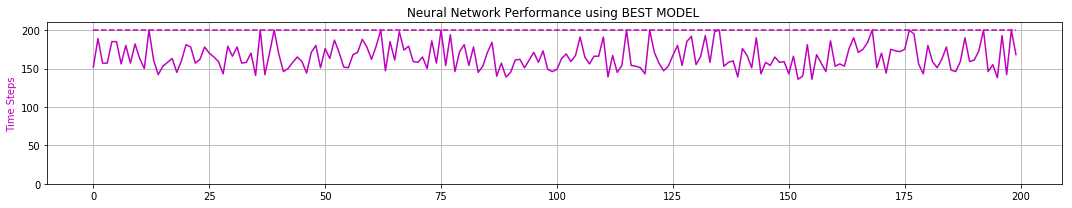

0 -max- [ 1.035  2.622  0.176  3.129]
0 -min- [-2.600 -4.421 -0.250 -3.370]

peak memory: 1878.44 MiB, increment: 976.97 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 1.062  2.580  0.175  3.092]
1 -min- [-2.600 -4.504 -0.250 -3.334]

peak memory: 1956.57 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.035  2.558  0.177  3.159]
2 -min- [-2.600 -4.527 -0.250 -3.291]

peak memory: 1956.57 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.028  2.566  0.178  3.070]
3 -min- [-2.600 -4.489 -0.250 -3.206]

peak memory: 1956.57 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.026  2.565  0.177  3.061]
4 -min- [-2.600 -4.497 -0.250 -3.227]

peak memory: 1956.57 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.040  2.591  0.181  3.103]
5 -min- [-2.600 -4.489 -0.250 -3.327]

peak memory: 1878.44 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.036  2.569  0.174  3.088]
6 -min- [-2.60

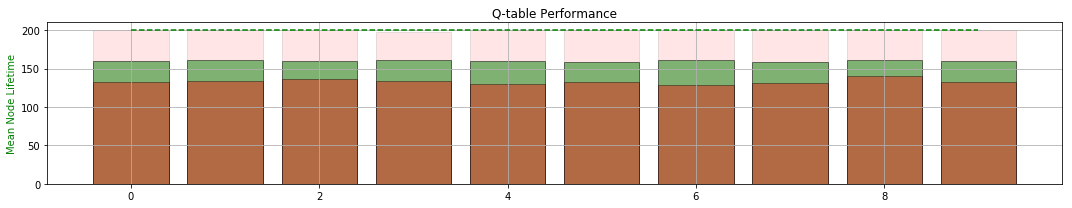

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 58.926	LOSS : 65.912	LOSS : 52.219	LOSS : 59.412	LOSS : 63.695	LOSS : 59.704	LOSS : 56.879	LOSS : 55.383	LOSS : 62.576	LOSS : 59.144	LOSS : 60.300	LOSS : 64.855	LOSS : 63.010	LOSS : 56.134	LOSS : 52.369	LOSS : 59.476	LOSS : 63.639	LOSS : 59.958	LOSS : 57.043	LOSS : 55.564	
Validating... MEAN TIME:  198.71
LOSS : 51.991	LOSS : 69.081	LOSS : 55.917	LOSS : 48.726	LOSS : 70.037	LOSS : 55.176	LOSS : 58.461	LOSS : 57.133	LOSS : 59.732	LOSS : 54.636	LOSS : 59.867	LOSS : 58.468	LOSS : 54.891	LOSS : 62.738	LOSS : 57.805	LOSS : 62.921	LOSS : 51.079	LOSS : 70.722	LOSS : 53.023	LOSS : 53.993	
Validating... MEAN TIME:  120.91
LOSS : 66.213	LOSS : 58.392	LOSS : 57.298	LOSS : 54.073	LOSS : 60.411	LOSS : 54.388	LOSS : 49.050	LOSS : 61.278	LOSS : 60.786	LOSS : 57.944	LOSS : 54.424	LOSS : 47.713	LOSS : 60.649	LOSS : 67.405	LOSS : 58.890	LOSS : 64.355	LOSS : 71.158	LOSS : 56.624	LOSS : 54.827	LOSS : 66.114	
Validati

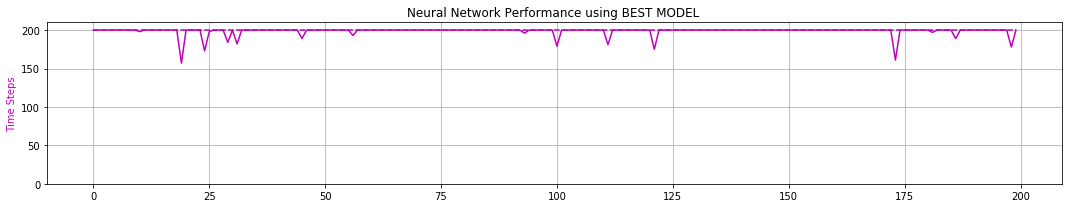

0 -max- [ 0.833  2.191  0.144  2.685]
0 -min- [-2.600 -4.122 -0.250 -2.771]

peak memory: 1921.39 MiB, increment: 976.78 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.843  2.225  0.144  2.686]
1 -min- [-2.600 -4.154 -0.247 -2.819]

peak memory: 1999.52 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.836  2.234  0.153  2.738]
2 -min- [-2.600 -4.178 -0.250 -2.798]

peak memory: 1921.39 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.828  2.228  0.147  2.618]
3 -min- [-2.600 -4.176 -0.248 -2.722]

peak memory: 1999.52 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.837  2.233  0.153  2.651]
4 -min- [-2.600 -4.186 -0.250 -2.746]

peak memory: 1921.39 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.840  2.255  0.153  2.789]
5 -min- [-2.600 -4.177 -0.246 -2.803]

peak memory: 1921.39 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.842  2.241  0.144  2.657]
6 -min- [-2.60

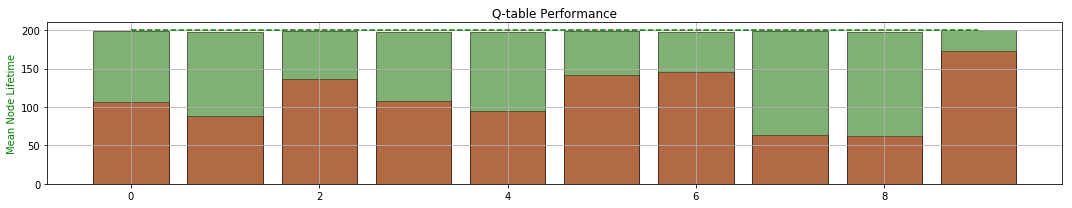

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        

    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    if iteration >= 4:
        for node_id in range(NO_OF_NODES):
            # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")

            # CREATE STATE COMBINATIONS
            ###############################################
            node_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN],
                                                [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX],
                                                [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])
            ###############################################
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    else:
        for node_id in range(NO_OF_NODES):

            # PRINT STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")
            #############################################################################################################################################
            node_state_combinations = init_state_combinations
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
            node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1419.0
Total Serial Timesteps   :  992344.0
Speed-up                 :  699.33


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS  62   8    1419     992344     699.33
